NOTEBOOK PROJECT MUSIC EMOTION

Pergunta principal: é possivel prever a emoção principal transmitida por uma musica (alegria, tristeza, euforia, etc.) com base em suas caracteristicas de áudio e metadados?

Será construido um algoritmo de predição que utiliza-rá modelos de classificação, atraves de logistic regression (para avaliar os coeficiente) e SVM com diferente kernel.

Em seguida prosseguiremos com a avaliação do modulo através de seu desempenho em teste_split (coluna target: 'emotion').

INICIANDO ETL

In [2]:
import pandas as pd
import numpy as np

df_original = pd.read_csv('F:/Repositorio local/repo-local/music-emocional/data/spotify_dataset.csv')
df = df_original.copy()

# Ajutando visualização no pandas
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None) 

print(df.head(20))

         Artist(s)                         song  \
0              !!!    Even When the Waters Cold   
1              !!!           One Girl / One Boy   
2              !!!            Pardon My Freedom   
3              !!!                          Ooo   
4              !!!                   Freedom 15   
5              !!!                All U Writers   
6              !!!                 Serbia Drums   
7              !!!             Must Be the Moon   
8              !!!                         Slyd   
9              !!!     Hello? Is This Thing On?   
10             !!!                   Myth Takes   
11             !!!              Heart of Hearts   
12             !!!                       Yadnus   
13             !!!                Sick Ass Moon   
14             !!!    All My Heroes Are Weirdos   
15             !!!           Couldnt Have Known   
16     !!!,Lea Lea  Dancing Is the Best Revenge   
17     !!!,Lea Lea                         NRGQ   
18          !Marc¡             

TARGET: coluna 'emotion'

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551443 entries, 0 to 551442
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Artist(s)                       551443 non-null  object 
 1   song                            551427 non-null  object 
 2   text                            551443 non-null  object 
 3   Length                          551443 non-null  object 
 4   emotion                         551443 non-null  object 
 5   Genre                           551443 non-null  object 
 6   Album                           551391 non-null  object 
 7   Release Date                    551443 non-null  object 
 8   Key                             551443 non-null  object 
 9   Tempo                           551443 non-null  int64  
 10  Loudness (db)                   551443 non-null  object 
 11  Time signature                  551435 non-null  object 
 12  Explicit        

FORMATAÇÃO DE COLUNAS

- Length esta em string, converter para timestamp
- Release Date em string, converter para datetime
- Loudness esta em string, converter para float e retirar este "db"


- Good for Party                  
- Good for Work/Study              
- Good for Relaxation/Meditation   
- Good for Exercise                
- Good for Running                 
- Good for Yoga/Stretching         
- Good for Driving                 
- Good for Social Gatherings       
- Good for Morning Routine        
- Converter TODOS ACIMA para bin

 O objetivo é trabalha-los para se tornar features

Antes da formatação será analisado os dados nulos/vazios e duplicados

In [4]:
df_null = df.isnull().sum()
print(df_null / len(df) * 100)

Artist(s)                         0.000000
song                              0.002901
text                              0.000000
Length                            0.000000
emotion                           0.000000
Genre                             0.000000
Album                             0.009430
Release Date                      0.000000
Key                               0.000000
Tempo                             0.000000
Loudness (db)                     0.000000
Time signature                    0.001451
Explicit                          0.000000
Popularity                        0.000000
Energy                            0.000000
Danceability                      0.000000
Positiveness                      0.000000
Speechiness                       0.000000
Liveness                          0.000000
Acousticness                      0.000000
Instrumentalness                  0.000000
Good for Party                    0.000000
Good for Work/Study               0.000000
Good for Re

Os valores nulos são irrisórios e praticamente insignificantes, será feita uma ultima verificação correlacionando eles com o target e serão removidos.


In [5]:
display(df[['emotion', 'song', 'Album', 'Time signature', 'Similar Song 1', 'Similar Song 2', 'Similar Song 3']].isna().sum())

emotion            0
song              16
Album             52
Time signature     8
Similar Song 1    19
Similar Song 2    20
Similar Song 3     4
dtype: int64

In [6]:
df.dropna(inplace=True)

Verificando duplicatas

In [7]:
df_duplicada = df.duplicated(keep=False)

# Contando linhas duplicadas
count_df_duplicada = df_duplicada.sum()

print(f"Número TOTAL de linhas no DataFrame: {len(df)}")
print(f"Número de linhas que SÃO parte de algum conjunto de duplicatas: {count_df_duplicada}")

# Exibindo as linhas duplicadas
df_duplicada_true = df[df_duplicada]

# ajustando a exibição para mostrar todas as colunas e linhas
pd.set_option('display.max_colwidth', 50) 
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None) 

if not df_duplicada_true.empty:
    print(f"\nEncontradas {len(df_duplicada_true)} linhas que são duplicatas.")
    print("Exemplo das primeiras linhas duplicadas:")
    
    try:
        display(df_duplicada_true.sort_values(by=list(df.columns)).head(10))
    except NameError:
        print(df_duplicada_true.sort_values(by=list(df.columns)).head(10))
else:
    print("\nNenhuma linha duplicada encontrada.")

Número TOTAL de linhas no DataFrame: 551324
Número de linhas que SÃO parte de algum conjunto de duplicatas: 68835

Encontradas 68835 linhas que são duplicatas.
Exemplo das primeiras linhas duplicadas:


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,Good for Party,Good for Work/Study,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Yoga/Stretching,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
318,$NOT,Mean,[Intro: $NOT] Brr [Chorus: $NOT] I'm a real n...,02:00,anger,hip hop,- TRAGEDY +,6th March 2020,C Maj,80,-10.14db,4/4,Yes,67,45,85,49,42,32,81,0,0,0,0,0,0,0,0,0,0,$NOT,Doja,1.0,$NOT,GOSHA,1.0,Aflacko,Cake,0.95872
319,$NOT,Mean,[Intro: $NOT] Brr [Chorus: $NOT] I'm a real n...,02:00,anger,hip hop,- TRAGEDY +,6th March 2020,C Maj,80,-10.14db,4/4,Yes,67,45,85,49,42,32,81,0,0,0,0,0,0,0,0,0,0,$NOT,Doja,1.0,$NOT,GOSHA,1.0,Aflacko,Cake,0.95872
320,$NOT,Mean,[Intro: $NOT] Brr [Chorus: $NOT] I'm a real n...,02:00,anger,hip hop,- TRAGEDY +,6th March 2020,C Maj,80,-10.14db,4/4,Yes,67,45,85,49,42,32,81,0,0,0,0,0,0,0,0,0,0,$NOT,Doja,1.0,$NOT,GOSHA,1.0,Aflacko,Cake,0.95872
355,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
356,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
357,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
358,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
359,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
360,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000
361,"$NOT,Wifisfuneral",NASTY,"[Verse 1: Robb Bank$] Bitch, I'm a big body Wr...",02:40,anger,hip hop,- TRAGEDY +,6th March 2020,F# min,96,-7.94db,4/4,Yes,55,56,81,22,32,8,16,0,0,0,0,0,0,0,1,0,0,"$NOT,Wifisfuneral",Okuur,1.0,"$NOT,Wifisfuneral",Cant Feel My Face,1.0,"$NOT,Wifisfuneral",Anything,1.00000


Existem muitas colunas duplicadas, e algumas que parecem ser a média de preenhcimento de outras colunas para manter o dataset intacto.

Embora seja um numero consideravel, elas serão removidas pois seguindo o objetivo de contruir um modelo preditivo, pois não tem muita utlidade para o modelo de predição. Modelos não aprendem com dados duplicados, além disso só serão excluidas as duplicadas EXATAMENTE iguais em todas as colunas. Logo, a coluna 'song' que contem o nome da musica (track_id) continuará sendo uma boa referência de ordenação.

Além disso esta ação evita um possivel enviesamento do modelo com base do target com médias repetitivas.

In [8]:
print(f"Número de linhas ANTES de remover duplicatas: {len(df)}")

df_sem_duplicadas = df.drop_duplicates(keep='first')

print(f"Número de linhas DEPOIS de remover duplicatas: {len(df_sem_duplicadas)}")


Número de linhas ANTES de remover duplicatas: 551324
Número de linhas DEPOIS de remover duplicatas: 497942


Iniciando formatações

In [9]:
# Convertendo Length de string para timedelta
df_sem_duplicadas['Length'] = df_sem_duplicadas['Length'].apply(
    lambda x: f"00:{x}" if len(str(x).split(':')) == 2 else x
)
df_sem_duplicadas['Length'] = pd.to_timedelta(df_sem_duplicadas['Length'])

df_sem_duplicadas['Release Date'] = pd.to_datetime(
    df_sem_duplicadas['Release Date'], 
    format='%d/%m/%Y',  # ou outro formato adequado
    errors='coerce',
    dayfirst=True
)


# Convertendo Release Date de string para datetime
df_sem_duplicadas['Release Date'] = pd.to_datetime(df_sem_duplicadas['Release Date'], errors='coerce', dayfirst=True)

# Convertendo Loudness de string para float, removendo "db"
df_sem_duplicadas['Loudness (db)'] = df_sem_duplicadas['Loudness (db)'].str.replace('db', '', regex=False).astype(float)

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3932860783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['Length'] = df_sem_duplicadas['Length'].apply(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3932860783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['Length'] = pd.to_timedelta(df_sem_duplicadas['Length'])
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3932860783.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [10]:
# Convertendo colunas int para bool

df_sem_duplicadas['Good for Party'] = df_sem_duplicadas['Good for Party'].astype(bool)
df_sem_duplicadas['Good for Work/Study'] = df_sem_duplicadas['Good for Work/Study'].astype(bool)
df_sem_duplicadas['Good for Relaxation/Meditation'] = df_sem_duplicadas['Good for Relaxation/Meditation'].astype(bool)
df_sem_duplicadas['Good for Exercise'] = df_sem_duplicadas['Good for Exercise'].astype(bool)
df_sem_duplicadas['Good for Running'] = df_sem_duplicadas['Good for Running'].astype(bool)
df_sem_duplicadas['Good for Yoga/Stretching'] = df_sem_duplicadas['Good for Yoga/Stretching'].astype(bool)
df_sem_duplicadas['Good for Driving'] = df_sem_duplicadas['Good for Driving'].astype(bool)
df_sem_duplicadas['Good for Social Gatherings'] = df_sem_duplicadas['Good for Social Gatherings'].astype(bool)
df_sem_duplicadas['Good for Morning Routine'] = df_sem_duplicadas['Good for Morning Routine'].astype(bool)
                  
df_sem_duplicadas.info()

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2517760135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['Good for Party'] = df_sem_duplicadas['Good for Party'].astype(bool)
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2517760135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['Good for Work/Study'] = df_sem_duplicadas['Good for Work/Study'].astype(bool)
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2517760135.py:5: SettingWithCopyWarning: 
A value is trying t

<class 'pandas.core.frame.DataFrame'>
Index: 497942 entries, 0 to 551442
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   Artist(s)                       497942 non-null  object         
 1   song                            497942 non-null  object         
 2   text                            497942 non-null  object         
 3   Length                          497942 non-null  timedelta64[ns]
 4   emotion                         497942 non-null  object         
 5   Genre                           497942 non-null  object         
 6   Album                           497942 non-null  object         
 7   Release Date                    0 non-null       datetime64[ns] 
 8   Key                             497942 non-null  object         
 9   Tempo                           497942 non-null  int64          
 10  Loudness (db)                   497942 non-null  

In [11]:
# Renomeando a coluna Tempo para especificar o significado
df_sem_duplicadas.rename(columns={'Tempo': 'Tempo_bpm'}, inplace=True)

df_sem_duplicadas.head(10)

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2662776714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas.rename(columns={'Tempo': 'Tempo_bpm'}, inplace=True)


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo_bpm,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,Good for Party,Good for Work/Study,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Yoga/Stretching,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,0 days 00:03:47,sadness,hip hop,Thr!!!er,NaT,D min,105,-6.85,4/4,No,40,83,71,87,4,16,11,0,False,False,False,False,False,False,False,False,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",0 days 00:04:03,sadness,hip hop,Thr!!!er,NaT,A# min,117,-5.75,4/4,No,42,85,70,87,4,32,0,0,False,False,False,False,False,False,False,False,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",0 days 00:05:51,joy,hip hop,Louden Up Now,NaT,A Maj,121,-6.06,4/4,No,29,89,71,63,8,64,0,20,False,False,False,True,False,False,False,False,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,0 days 00:03:44,joy,hip hop,As If,NaT,A min,122,-5.42,4/4,No,24,84,78,97,4,12,12,0,False,False,False,True,False,False,False,False,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,0 days 00:06:00,joy,hip hop,As If,NaT,F min,123,-5.57,4/4,No,30,71,77,70,7,10,4,1,False,False,False,True,False,False,False,False,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415
5,!!!,All U Writers,All you writers Get out your pens and write Al...,0 days 00:05:22,love,hip hop,All U Writers / Gonna Guetta Stomp,NaT,B min,122,-7.00,4/4,No,26,81,87,74,4,7,0,47,False,False,False,True,False,False,False,False,False,Wish & Fonda Rae,Touch Me All Night Long,0.980839,Gary Numan,War Songs,0.980527,Little Dragon,Forever,0.980209
6,!!!,Serbia Drums,[Verse 1] We've known working in obscurity and...,0 days 00:03:39,sadness,hip hop,Wallop,NaT,E min,104,-6.86,4/4,No,17,89,68,65,8,9,0,0,False,False,False,False,False,False,False,False,False,Talking Heads,Ruby Dear,0.980781,Hanson,Something Going Round,0.979205,"Hoodie Allen,Jared Evan",Same As Before,0.978977
7,!!!,Must Be the Moon,"One drink, two drinks, three drinks, four She ...",0 days 00:05:57,joy,hip hop,Myth Takes,NaT,G Maj,120,-5.00,4/4,No,27,88,77,95,5,34,0,4,False,False,False,False,False,False,False,False,False,"Crystal Waters,Steve ""Silk"" Hurley",Makin Happy,0.985045,Marvin Gaye,Sanctified Lady,0.974169,Ready For The World,Digital Display,0.973508
8,!!!,Slyd,"No, that's weird Slyd, slyd, slyd, you like t...",0 days 00:04:14,surprise,hip hop,Thr!!!er,NaT,C Maj,120,-8.73,4/4,No,33,72,86,58,10,22,6,24,False,False,False,False,False,False,False,False,False,"Moon Boots,Fiora",I Want Your Attention,0.992940,"Rhombus,Tiki Taane,MC Antsman,Imon Starr",Seen It All Beast Mix,0.991243,"Craig Reever,Easton",Special about You,0.989623
9,!!!,Hello? Is This Thing On?,Sometimes you don't say nothing 'cause you got...,0 days 00:07:33,sadness,hip hop,Louden Up Now,NaT,G Maj,124,-8.24,4/4,No,21,68,77,67,4,10,5,0,False,False,False,True,False,False,False,False,True,Midnight Star,Operator,0.985598,"Boris Dlugosch,Róisín Murphy,Ricky Mattioli",Never Enough,0.979075,YACHT,Miles Miles,0.978798


Aqui tem um problema, a coluna de data Release Date não estava conseguindo ser formata para datetime por conta do conteúdo da string. 
Vou retoma-la no formato inicial e formatar os dados antes de formatar a coluna.

In [12]:
# Organizando coluna Release Date no formato datetime
df_sem_duplicadas['Release Date'] = df['Release Date']

df_sem_duplicadas['Release Date'].head(10)

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\489528745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['Release Date'] = df['Release Date']


0      29th April 2013
1      29th April 2013
2        8th June 2004
3    16th October 2015
4    16th October 2015
5      27th April 2015
6     30th August 2019
7       5th March 2007
8      29th April 2013
9        8th June 2004
Name: Release Date, dtype: object

In [13]:
# Formatando os dados utilizando regex, e depois tentar forçar o pandas a converter para datetime

import re

def cleaning_sufix_day(texto_da_data): 
    if isinstance(texto_da_data, str): 
        
        return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', texto_da_data)
    return texto_da_data


df_sem_duplicadas['release_data_cleaned'] = df_sem_duplicadas['Release Date'].apply(cleaning_sufix_day)

# Forçando a conversão para datetime com tratamento de erros
try:
    # Tenta converter a coluna limpa
    df_sem_duplicadas['release_date_format'] = pd.to_datetime(df_sem_duplicadas['release_data_cleaned'], format='%d %B %Y')
except ValueError as e:
    print(f"Erro ao converter com formato específico '%d %B %Y': {e}")
    print("Tentando conversão inferindo o formato")
   
    df_sem_duplicadas['release_date_format'] = pd.to_datetime(df_sem_duplicadas['release_data_cleaned'], errors='coerce')

except Exception as ex: 
    print(f"Ocorreu um erro inesperado: {ex}")
    
    df_sem_duplicadas['release_date_format'] = pd.NaT


print("\ndf após conversão para datetime (corrigido):")
print(df_sem_duplicadas[['Release Date', 'release_data_cleaned', 'release_date_format']].head())

print("\nTipos de dados:")
print(df_sem_duplicadas.dtypes)


df após conversão para datetime (corrigido):
        Release Date release_data_cleaned release_date_format
0    29th April 2013        29 April 2013          2013-04-29
1    29th April 2013        29 April 2013          2013-04-29
2      8th June 2004          8 June 2004          2004-06-08
3  16th October 2015      16 October 2015          2015-10-16
4  16th October 2015      16 October 2015          2015-10-16

Tipos de dados:
Artist(s)                                  object
song                                       object
text                                       object
Length                            timedelta64[ns]
emotion                                    object
Genre                                      object
Album                                      object
Release Date                               object
Key                                        object
Tempo_bpm                                   int64
Loudness (db)                             float64
Time signature 

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2745123331.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['release_data_cleaned'] = df_sem_duplicadas['Release Date'].apply(cleaning_sufix_day)
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\2745123331.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['release_date_format'] = pd.to_datetime(df_sem_duplicadas['release_data_cleaned'], format='%d %B %Y')


In [14]:
df_sem_duplicadas['release_date_format']

0        2013-04-29
1        2013-04-29
2        2004-06-08
3        2015-10-16
4        2015-10-16
            ...    
551438   2020-10-14
551439   2022-04-19
551440   2023-08-30
551441   2008-06-03
551442   2020-11-04
Name: release_date_format, Length: 497942, dtype: datetime64[ns]

A partir de agora, com o dataset pronto, será iniciado a fase de pré-processamento EDA, com a seguinte contextualização:

- As classes do target estão nitidamente desbalanceadas (foi possivel observar isso usando a extensão Data Wrangler) e isso será um problema para o modelo.
- Uma saída viavel é afunilar algumas classes (especialmente as com provaveis semelhanças, ex: "anger" e "angry") e analisar como as features de classe majoritaria, intermediária e minoritária se comportam em seus agrupamentos de classe.
- O objetivo atual será melhorar o agrupamento das classes para ajudar o SVM e dimensionar uma margem eficiênte.

- Hipótese: Até onde será possivel balancear o conjunto de multiclasses sem enviezar o modelo?

Algumas caracteristicas da coluna parecem redundantes e com erros de digitação, outras se apresentam muito semelhantes, estas serão exploradas e caso tenham features muitos semelhantes, serão mescladas com o objetivo de refinar a métrica do modelo.

In [15]:
#passando o conteúdo da coluna 'emotion' para minúsculo
df_sem_duplicadas['emotion'] = df_sem_duplicadas['emotion'].str.lower()

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3687182916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['emotion'] = df_sem_duplicadas['emotion'].str.lower()


Vamos usar um violinplot para analisar a semelhança das classes com base nas possiveis features do tipo int e float

e um grafico de barras por proporções para tipos de dados bool das possiveis features

In [16]:
df_sem_duplicadas

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo_bpm,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,Good for Party,Good for Work/Study,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Yoga/Stretching,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3,release_data_cleaned,release_date_format
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,0 days 00:03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,-6.85,4/4,No,40,83,71,87,4,16,11,0,False,False,False,False,False,False,False,False,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236,29 April 2013,2013-04-29
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",0 days 00:04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,-5.75,4/4,No,42,85,70,87,4,32,0,0,False,False,False,False,False,False,False,False,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483,29 April 2013,2013-04-29
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",0 days 00:05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,-6.06,4/4,No,29,89,71,63,8,64,0,20,False,False,False,True,False,False,False,False,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752,8 June 2004,2004-06-08
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,0 days 00:03:44,joy,hip hop,As If,16th October 2015,A min,122,-5.42,4/4,No,24,84,78,97,4,12,12,0,False,False,False,True,False,False,False,False,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381,16 October 2015,2015-10-16
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,0 days 00:06:00,joy,hip hop,As If,16th October 2015,F min,123,-5.57,4/4,No,30,71,77,70,7,10,4,1,False,False,False,True,False,False,False,False,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415,16 October 2015,2015-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551438,박혜진 Park Hye Jin,Can you,Can you be my (Can you be my) Can you be my (C...,0 days 00:03:39,joy,house,Can you (Galcher Lustwerk Remix),14th October 2020,B min,140,-10.00,4/4,Yes,31,82,83,19,16,9,39,72,False,False,False,True,False,False,False,False,False,LXST CXNTURY,NEVER EXISTED,0.946429,"Occvlt,StoneDogg",ALIZAY,0.926155,Peaches,Light in Places,0.923749,14 October 2020,2020-10-14
551439,심형진 Hyungjin Sim,Lim Han Byul Lee Hyuk - Prayer English Transl...,[Verse] I gave you my everything But I see I c...,0 days 00:08:47,joy,metalcore,비 준비하시니 Psalm_147,19th April 2022,G# Maj,128,-9.68,4/4,No,29,43,39,26,3,10,54,0,False,False,False,False,False,False,False,False,False,Kari Jobe,No Fear Live,0.991961,"The Belonging Co,Kari Jobe",Closer To Your Heart,0.990956,Saintseneca,Pillar of Na,0.990385,19 April 2022,2022-04-19
551440,우정하,Memories Smiling Tears Remix,"[Tasha] Hell on earth, watching ...",0 days 00:03:53,sadness,hip hop,MEMORY,30th August 2023,G# min,75,-4.67,4/4,No,21,79,56,41,5,19,0,0,False,False,False,False,False,False,False,False,False,Manic Street Preachers,People Give In,0.982809,Vinyl Theatre,Gold,0.980835,Unspoken,Life in the Death of Me,0.980171,30 August 2023,2023-08-30
551441,제노,Come Back to Me,[Verse] Gifts and flowers lay upon the lid Of ...,0 days 00:03:12,sadness,hip hop,2008 to me again,3rd June 2008,E Maj,126,-3.93,4/4,No,5,90,59,69,4,7,27,0,False,False,False,True,False,False,False,False,False,B

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


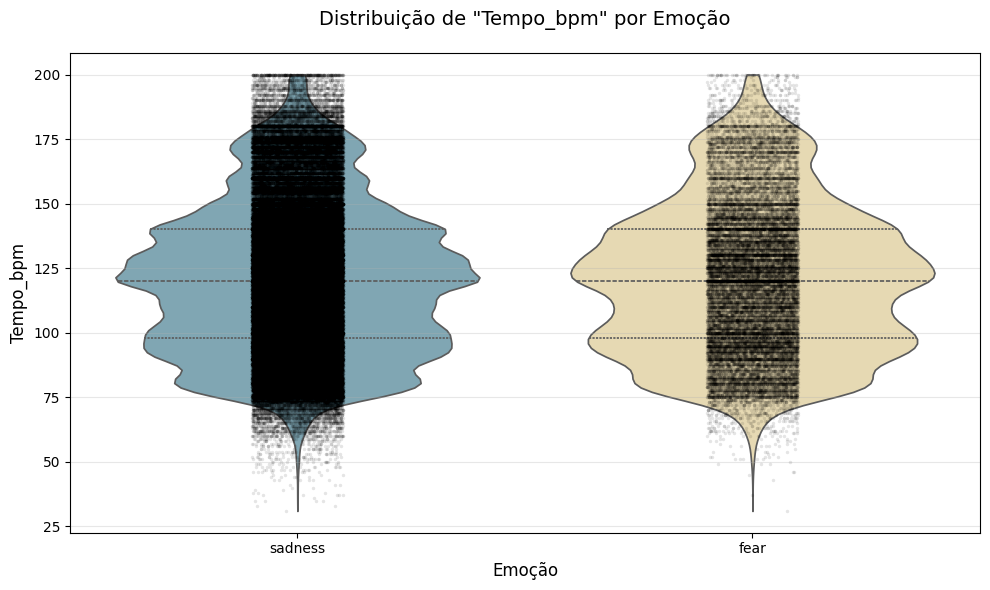

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


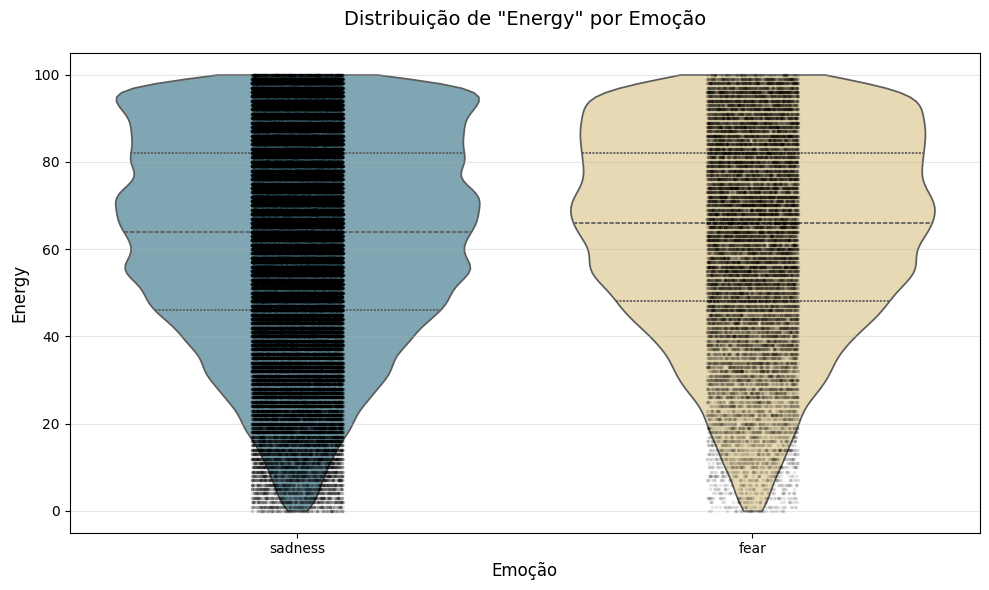

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


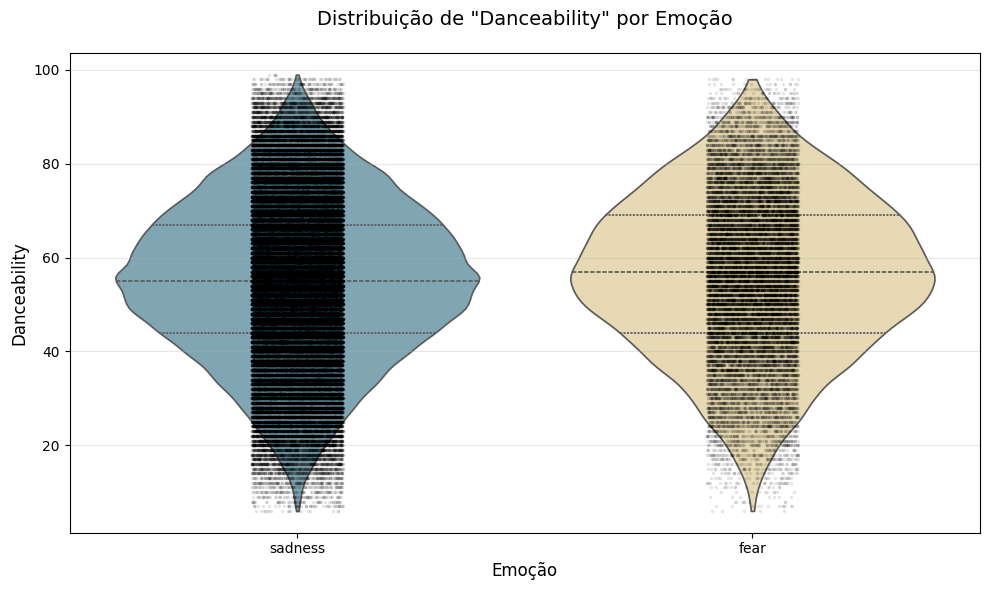

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


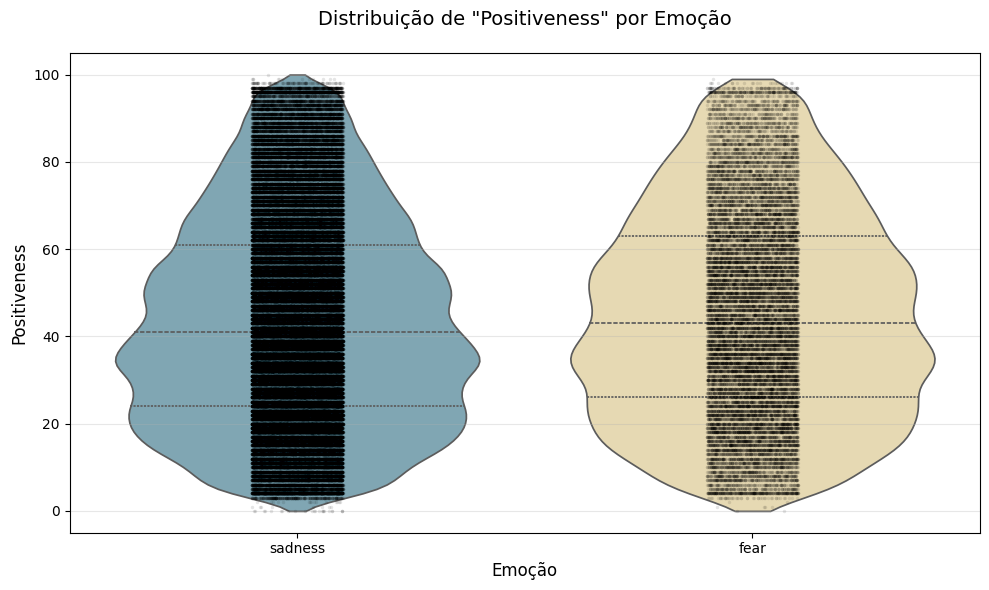

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


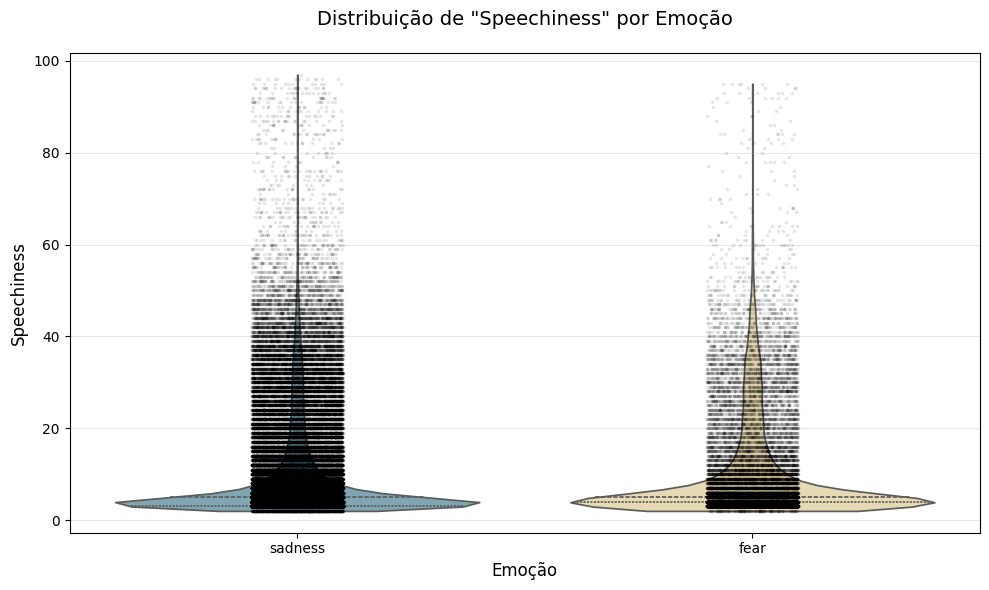

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


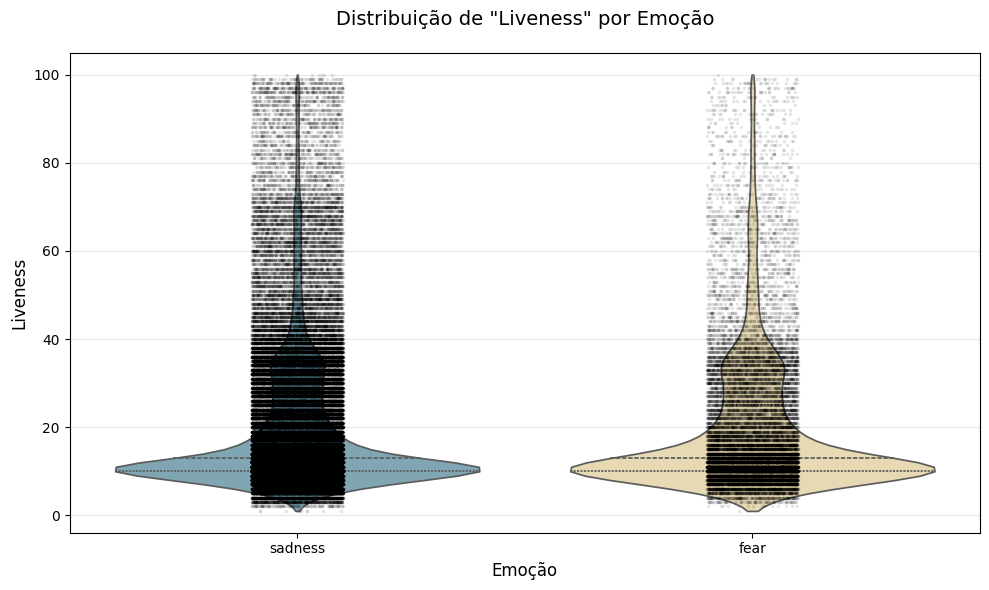

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


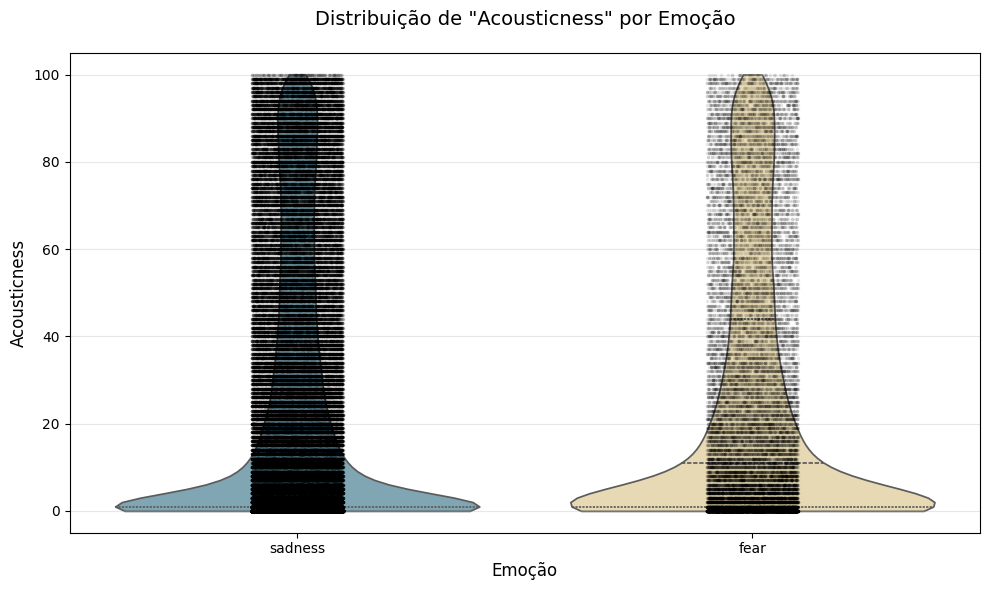

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\669061665.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


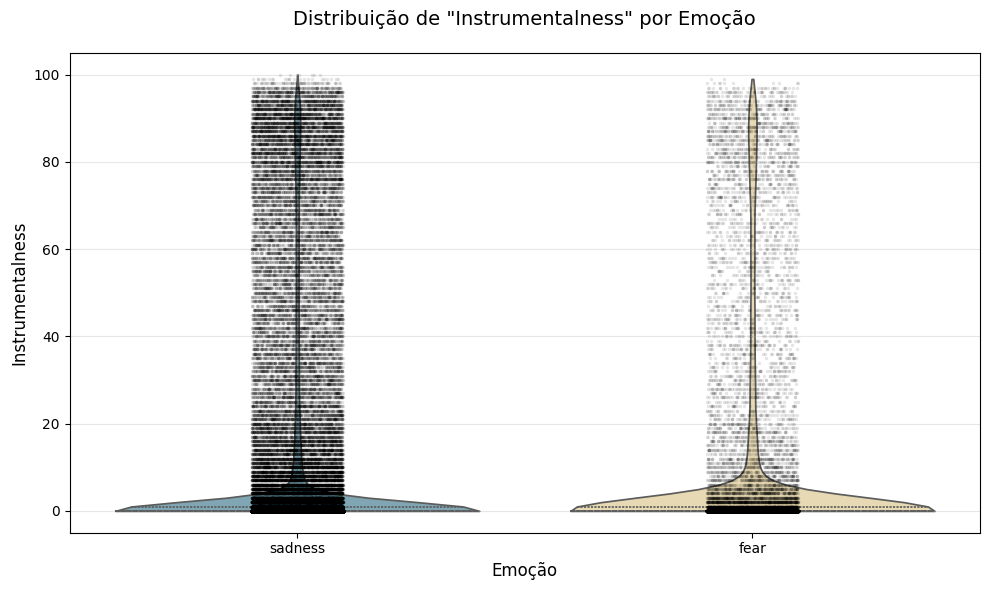

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando variaveis de comparação
classes_para_comparar = ['fear', 'sadness']
df_comparacao_classes = df_sem_duplicadas[df_sem_duplicadas['emotion'].isin(classes_para_comparar)]


features_int = ['Tempo_bpm', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 
                'Liveness', 'Acousticness', 'Instrumentalness']


for feature in features_int:
    plt.figure(figsize=(10, 6))
    
   
    sns.violinplot(
        x='emotion', 
        y=feature, 
        data=df_comparacao_classes,
        inner='quartile',
        palette="blend:#7AB,#EDA",    
        cut=0,             
        scale='width'
    )
    
    
    sns.stripplot(
        x='emotion', 
        y=feature, 
        data=df_comparacao_classes,
        color='black',       
        alpha=0.1,           
        jitter=True,         
        size=2.5            
    )
    
    plt.title(f'Distribuição de "{feature}" por Emoção', fontsize=14, pad=20)
    plt.xlabel('Emoção', fontsize=12)
    plt.ylabel(feature.capitalize(), fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Analisando grafico emoção x tempo bpm
- Linha mediana muito semelhante, o que indica similaridade no volume do ponto central (entre 115 a 125bpm)
- Distribuição interquatis IQR com semelhança consistente, indicando que 50% de informação dos dados esta na mesma zona de informação.
- Zona de disperção concentrada no IQR na classe 'sadness' e com uma intensidade um pouco mais fechada na classe 'fear', indicando que embora exista uma difenreça de disperção além da proporcionalidade de quantidade dados, os valores que traçam a verossimilhaça da feature seguem sendo semelhantes.
- Uma observação interessante é o fato de ambas as classes terem uma oscilação consideravel entre dois picos distintos, as musicas entre 125 e 150bpm e as musicas abaixo de 100bpm (demonstrando a particularidade do gênero musical em detrimento da emoção).

Analisando grafico emoção x energy
- Concentração mais de disperção nos valores entre 50 a 100 ponto na classe sadness, e 60 a 90 pontos na classe fear. Indicando relativa semelhança.
- Verosimilhança levemente diferente, especialmente no 1 quartis e 3 quartis. A classe sadness apresenta um pouco mais de heteregeneidade nos picos de informação no 1 quartil do que a classe fear (que se apresenta mais uniforme).
- A mediana da classe fear esta concentrada em 65 pontos, enquanto a da classe sadness esta em 63 pontos.

Analisando grafico emoção x danceability
- Muita semelhança na dispersão dos dados e na uniformidade das informações, especialmente na area IQR.
- Discreta diferença entre as medianas, seguida por um pico de intensidade de informação na altura 57 da classe sadness
- As classes apresenta uma boa semelhança

Analisando grafico emoções x positiveness
- Concentração da disperção semelhantes no IQR, contudo um volume maior de dados da classe sadness abaixo do 1 quartil, especialmente nos níveis de intensidade 10 e 18.
- Leve diferença de valor na médiana e na area do IQR. Indicando uma discreta diferença na verosimilhança, porém, ainda com o formado semelhante.

Sobre os graficos com Speechiness, Liveness, Acousticness, Instrumentalness:
- Todos eles apresentam um grande semenlhança e as poucas diferenças são quase indetectaveis.
- Contudo, especialmente no grafico acousticness é possivel ver um diferença na dispeção dos dados, a classe sadness tem mais distruição entre os valores, enquanto a fear se cocnentra mais na região do 1 quartil.

Conclusão: Certamente unir essas classes irá ajudar o modelo a classificar melhor, elas são muitos semelhantes e apresentam um verossimilhança homogenea. Chamando atenção para alguns outliers e poucos picos de diferença que quando comparado com a disposição da disperção ou a area do IQR (elementos relevantes na caracterização das classes) se tornam passiveis de executar uma mesclagem.


In [18]:
# Unificando classes sadness e fear e chamando de negative_valence (valência negativa)
df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion'].replace({'sadness': 'negative_valence', 'fear': 'negative_valence'})

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\1902858468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion'].replace({'sadness': 'negative_valence', 'fear': 'negative_valence'})


In [19]:
df_sem_duplicadas['emotion_grouped'].value_counts()

# Corrigindo erro de semelhanças
df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion_grouped'].replace('angry', 'anger')

# As classes minoritarias estão muitos diferentes e com proporções irrelevantes para o treinamento do modelo.
# Elas serão agrupas others
df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion_grouped'].replace(
    ['true', 'surprise', 'thirst', 'confusion', 'pink', 'interest'], 'others')

df_sem_duplicadas['emotion_grouped'].value_counts()

C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3477553935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion_grouped'].replace('angry', 'anger')
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\3477553935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_duplicadas['emotion_grouped'] = df_sem_duplicadas['emotion_grouped'].replace(


emotion_grouped
joy                 189323
negative_valence    182775
anger                95469
love                 25379
others                4996
Name: count, dtype: int64

EDA das features
Iniciando analise de relacionamento entre as classes e as features int:



C:\Users\PC\AppData\Local\Temp\ipykernel_14616\1756707832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\1756707832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\1756707832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_14616\1756707832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue`

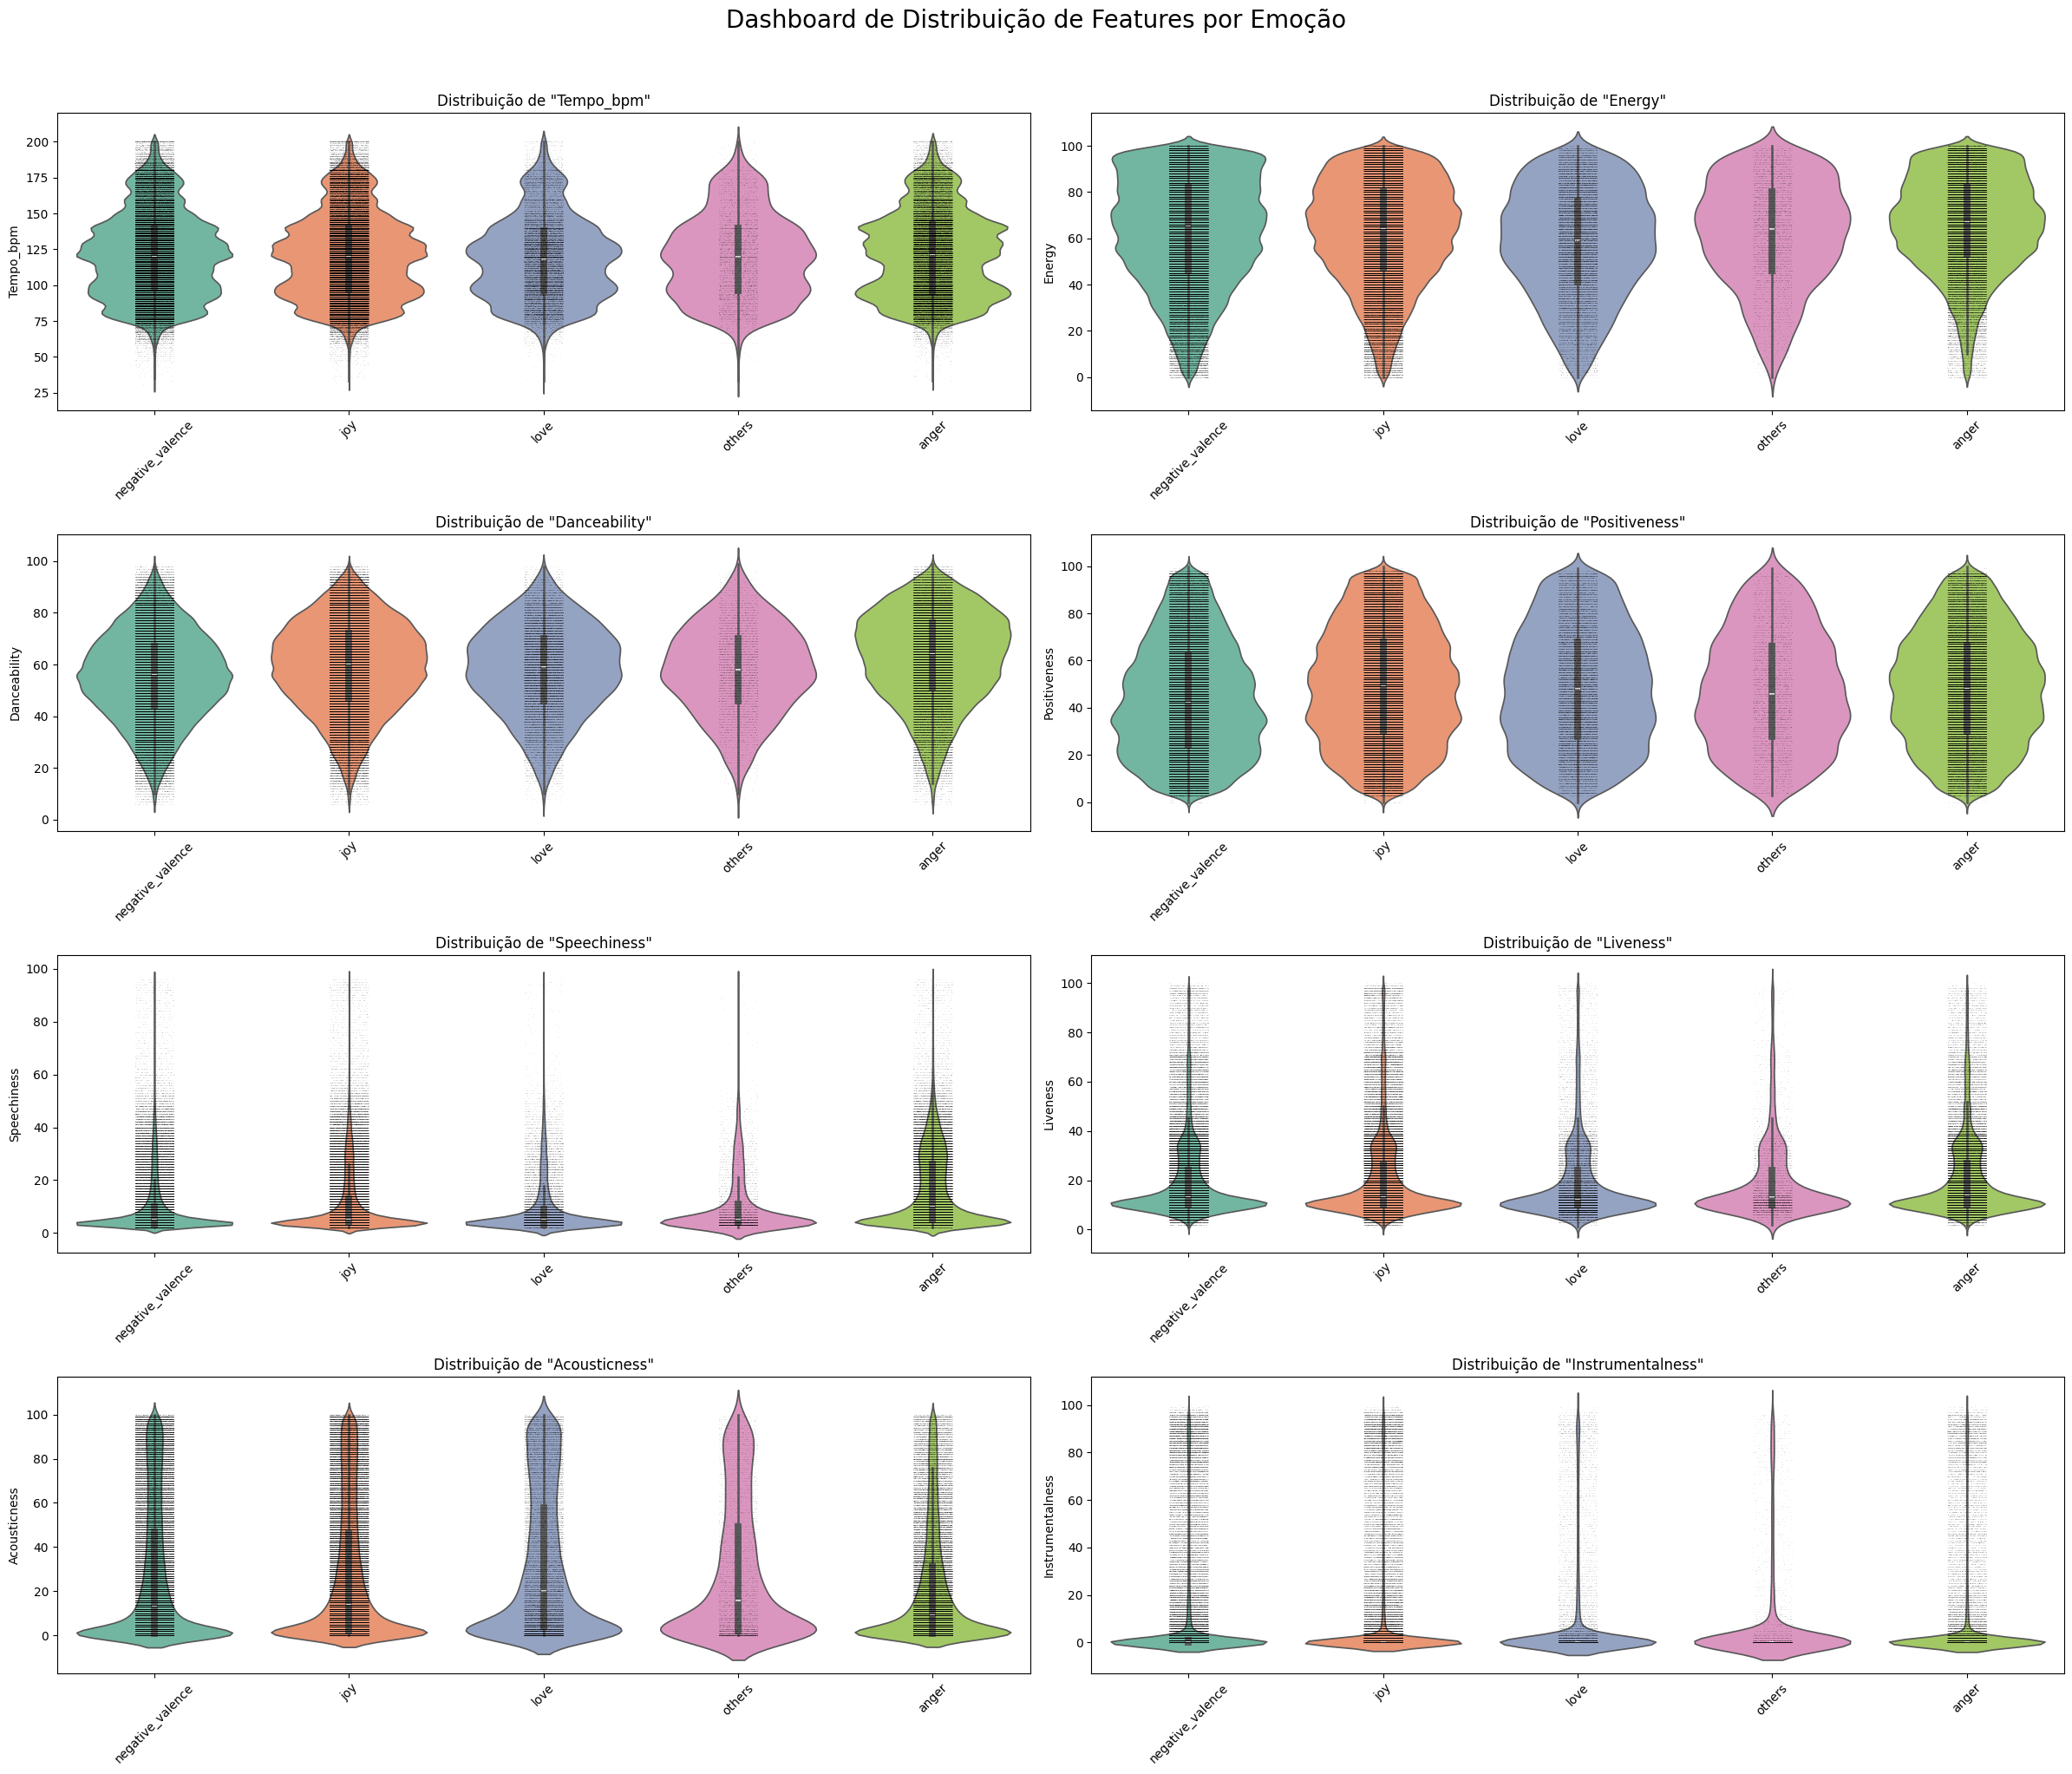

In [20]:


# Criando o dashboard de distribuição de features por emoção
features_bool = ['Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 
                 'Good for Running', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine']

# Será aplicado o mesmo grafico de distribuição para as features booleanas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 20))

# Ajustando o layout
axes = axes.flatten()

for i, feature in enumerate(features_int):
    ax = axes[i] 
    sns.violinplot(
        data=df_sem_duplicadas, 
        x='emotion_grouped', 
        y=feature, 
        ax=ax, 
        palette='Set2'
    )
    sns.stripplot(
        x='emotion_grouped', 
        y=feature, 
        data=df_sem_duplicadas,
        color='black',       
        alpha=0.1,           
        jitter=True,         
        size=0.5,
        ax=ax            
    )
    ax.set_title(f'Distribuição de "{feature}"')
    ax.set_xlabel('') 
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Dashboard de Distribuição de Features por Emoção', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


- A feature Tempo_bpm embora não discrimine relativamente bem a classe anger e love (dois picos no graifo). Ela sozinha não consegue fazer uma boa avaliação de forma geral.
- Energy parece um bom preditor, ele divide as classes anger e joy da love e negative_valence. Inclusive a unica mediana levemente abaixo do agrupamento é da classe love.
- Danceability claramente destaca a classe anger, esta é uma feature pontecilamente boa para o modelo.
- Speechiness e liveness estão muito a quem no quesito valor, é o provavel que o modelo não dê muita importância e suas disparidades são muito discretas se comparadas as outras. A priopri não será utilizada como feature. A única identidade que ela pode proporcionar (de forma rasa) é para classe anger, a qual já pode ser muito bem destacada pela classe danceability.
- Acousticness destaca bem a classe love, o próprio IQR de distribuição é notóriamente diferente das outras classes.

Prosseguindo para analise da features booleanas

O objetivo, assim como das features int, é observar como as possiveis features booleanas se relacionam com as classes.

In [21]:
#Agrupando por emoção e calculando a média das colunas booleanas
df_gby_mean_features_bool = df_sem_duplicadas.groupby('emotion_grouped')[features_bool].mean()


features_bool

['Good for Party',
 'Good for Work/Study',
 'Good for Relaxation/Meditation',
 'Good for Exercise',
 'Good for Running',
 'Good for Driving',
 'Good for Social Gatherings',
 'Good for Morning Routine']

In [22]:
df_gby_mean_features_bool

,Good for Party,Good for Work/Study,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Driving,Good for Social Gatherings,Good for Morning Routine
emotion_grouped,,,,,,,,
anger,0.059328,0.040882,0.015827,0.226105,0.071489,0.062858,0.009165,0.065194
joy,0.054816,0.080688,0.033329,0.189063,0.054167,0.056158,0.009893,0.066109
love,0.050987,0.117262,0.049647,0.161117,0.041215,0.058158,0.011348,0.071713
negative_valence,0.044459,0.087113,0.035831,0.160421,0.044300,0.048683,0.008448,0.059111
others,0.050440,0.089672,0.035228,0.167934,0.054043,0.050040,0.009207,0.062850


In [23]:

# O seaborn estava tendo dificuldade para plotar os dados com o formato original, então será necessário alongar e discriminar os dados para o formato longo.
df_gby_mean_features_bool = df_sem_duplicadas.groupby('emotion_grouped')[features_bool].mean().reset_index()

df_long_proporcoes = df_gby_mean_features_bool.melt(
    id_vars='emotion_grouped', 
    var_name='feature', 
    value_name='proportion'
)

print(df_long_proporcoes.head())

    emotion_grouped         feature  proportion
0             anger  Good for Party    0.059328
1               joy  Good for Party    0.054816
2              love  Good for Party    0.050987
3  negative_valence  Good for Party    0.044459
4            others  Good for Party    0.050440


C:\Users\PC\AppData\Local\Temp\ipykernel_14616\4289443332.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


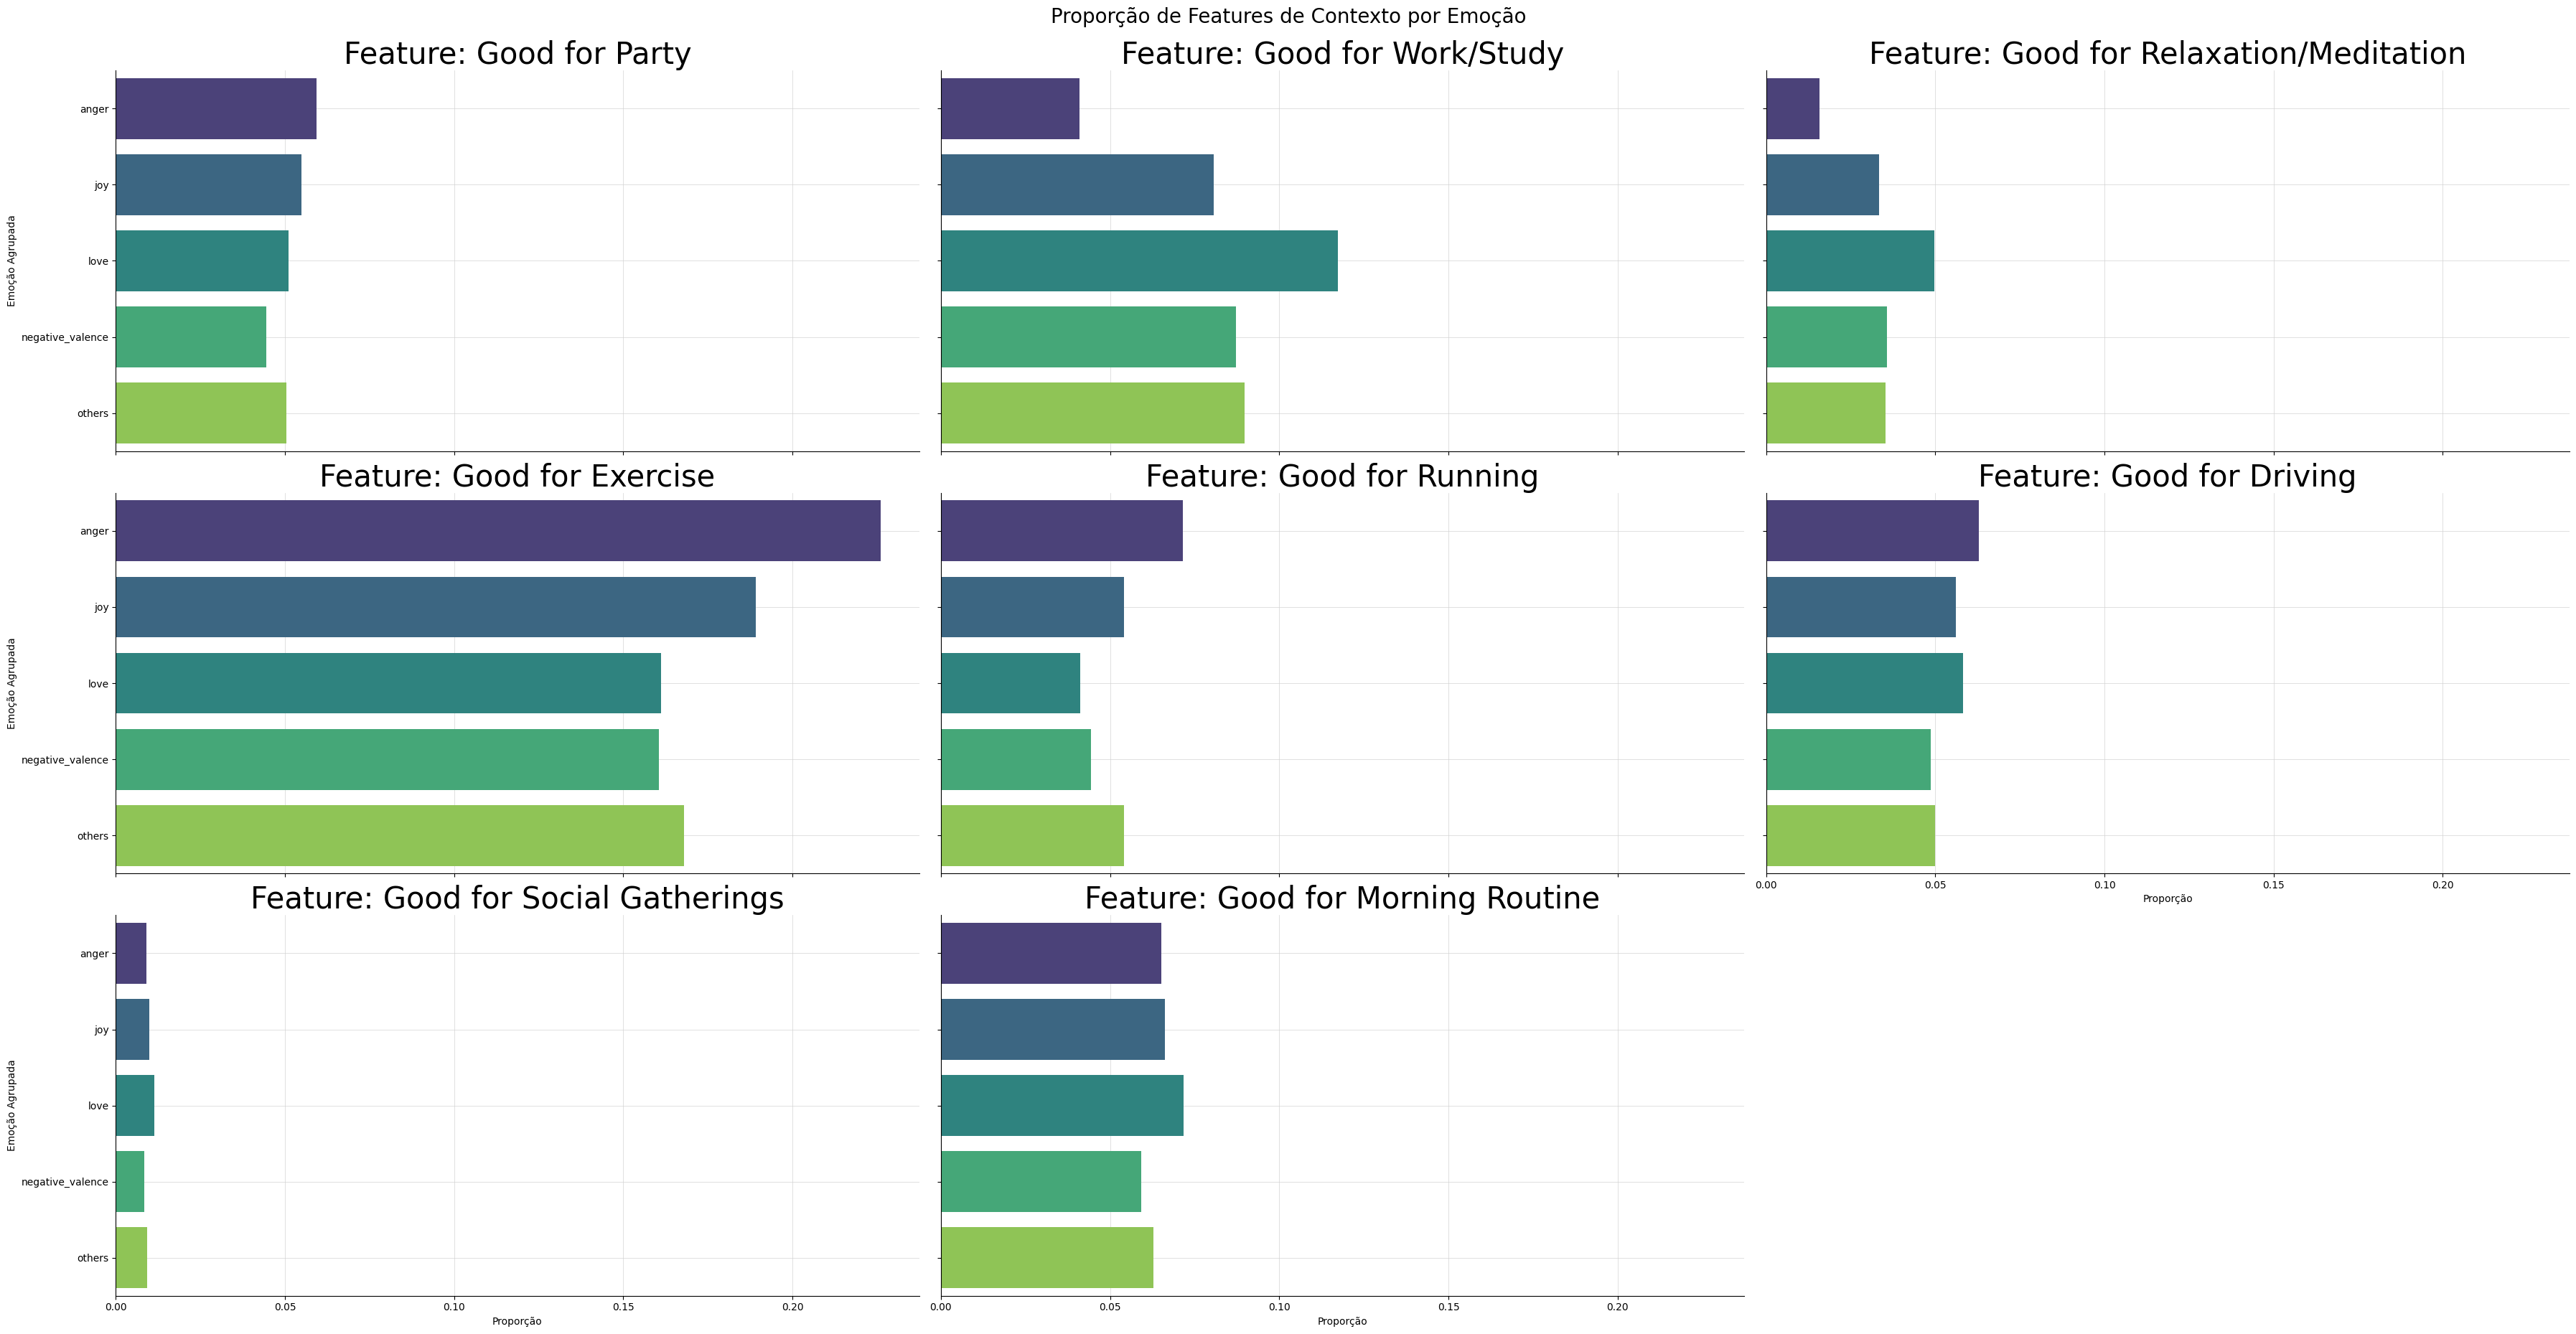

In [24]:
# Criando catplot

g = sns.catplot(
    data=df_long_proporcoes,
    kind='bar',             # Especifica que queremos um gráfico de barras
    x='proportion',         # O comprimento da barra será a proporção
    y='emotion_grouped',    # As categorias (emoções) ficarão no eixo Y
    col='feature',          # <--- A MÁGICA! Cria uma coluna de gráficos para cada feature
    col_wrap=3,             # Quebra a linha após 2 gráficos, para não ficar muito largo
    height=6,               # Altura de cada subplot
    aspect=2,               # Proporção largura/altura de cada subplot
    palette='viridis',      # Paleta de cores
    sharex=True,            # Mantém o mesmo eixo X para todos os gráficos para comparação fácil
    sharey=True             # Mantém o mesmo eixo Y
)

# Adiciona a grade mais detalhada a cada subplot
for ax in g.axes.flat:
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgray')
    ax.set_axisbelow(True)

# Ajustes finais para melhorar a legibilidade
g.fig.suptitle('Proporção de Features de Contexto por Emoção', y=1.03, fontsize=20)
g.set_titles("Feature: {col_name}", size=30) # Customiza o título de cada subplot
g.set_axis_labels("Proporção", "Emoção Agrupada")

# Rotação dos títulos dos subplots para o caso de serem muito longos
# (neste caso, não é necessário, mas é bom saber que é possível)
# for ax in g.axes.flat:
#     ax.set_title(ax.get_title(), rotation=0)

plt.show()

Sem sombra de duvidas todas serão features, elas tem uma boa distribuição e verossimilhança entre as classes.
- Good for Exercise e Good for Relaxation/Meditation se mostraram uteis sendo uma praticamente o oposto da outra. Traduzindo para o modelo o perfil de cada sentimento (classe), as demais features tem um leve complemento mas com certeza o modelo vai levar em consideração a noção principal de Felicidade:atividade fisica, comunicação, sociabilidade | Tristeza:melancolia, pouca fala, sem exercício, sem interação.

Finalizado a EDA, agora serão testados os modelos.

In [27]:
df_final = df_sem_duplicadas

df_final.info()

# Salvando em parquet para não perder os tipos de dados
df_final.to_parquet('df_final_para_modeling.parquet')

<class 'pandas.core.frame.DataFrame'>
Index: 497942 entries, 0 to 551442
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   Artist(s)                       497942 non-null  object         
 1   song                            497942 non-null  object         
 2   text                            497942 non-null  object         
 3   Length                          497942 non-null  timedelta64[ns]
 4   emotion                         497942 non-null  object         
 5   Genre                           497942 non-null  object         
 6   Album                           497942 non-null  object         
 7   Release Date                    497942 non-null  object         
 8   Key                             497942 non-null  object         
 9   Tempo_bpm                       497942 non-null  int64          
 10  Loudness (db)                   497942 non-null  